In [1]:
%matplotlib inline

In [10]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import matplotlib as mpl
mpl.style.use('seaborn-white')

from functools import partial
from scipy.linalg import toeplitz
import numpy as np
import pandas as pd
import cooler
import bioframe
import bioframe.dask
import dask
import distributed

#import pileups
import mirnylib.plotting

In [35]:
def make_bin_aligned_windows(binsize, chroms, centers_bp, flank_bp=0, 
                             region_start_bp=0, ignore_index=False):
    """
    Convert genomic loci into bin spans on a fixed bin-size segmentation a genomic region. 
    Window limits are adjusted to align with bin edges.
    
    Parameters
    -----------
    binsize : int
        Bin size (resolution) in base pairs.
    chroms : 1D array-like
        Column of chromosome names.
    centers_bp : 1D or nx2 array-like
        If 1D, center points of each window. If 2D, the starts and ends.
    flank_bp : int
        Distance in base pairs to extend windows on either side.
    region_start_bp : int, optional
        If region is a subset of a chromosome, shift coordinates by this amount.
        Default is 0.
    
    Returns
    -------
    DataFrame with columns: 
        'chrom'        - chromosome
        'start', 'end' - window limits in base pairs
        'lo', 'hi'     - window limits in bins
    
    """
    if not (flank_bp % binsize == 0):
        raise ValueError("Flanking distance must be divisible by the bin size.")
    
    if isinstance(chroms, pd.Series) and not ignore_index:
        index = chroms.index
    else:
        index = None
    
    chroms = np.asarray(chroms)
    centers_bp = np.asarray(centers_bp)
    if len(centers_bp.shape) == 2:
        left_bp = centers_bp[:, 0]
        right_bp = centers_bp[:, 1]
    else:
        left_bp = right_bp = centers_bp
    
    if np.any(left_bp > right_bp):
        raise ValueError("Found interval with end > start.")
    
    left = left_bp - region_start_bp
    right = right_bp - region_start_bp
    left_bin = (left / binsize).astype(int)
    right_bin = (right / binsize).astype(int)
    flank_bin = flank_bp // binsize
    
    lo = left_bin - flank_bin
    hi = right_bin + flank_bin + 1
    windows = pd.DataFrame(index=index)
    windows['chrom'] = chroms
    windows['start'] = lo * binsize
    windows['end'] = hi * binsize
    windows['lo'] = lo
    windows['hi'] = hi
    return windows


def assign_regions(features, supports):
    
    features = features.copy()
    
    # on-diagonal features
    if 'chrom' in features.columns:
        for i, region in enumerate(supports):
            if len(region) == 3:
                sel = (features.chrom == region[0])
                sel &= (features.end >= region[1])
                if region[2] is not None:
                    sel &= (features.start < region[2])
                
                features.loc[sel, 'region'] = i
                
            elif len(region) == 2:
                region1, region2 = region
                sel1 = (features.chrom == region1[0])
                sel1 &= (features.end >= region1[1])
                if region1[2] is not None:
                    sel1 &= (features.start < region1[2])
                
                sel2 = (features.chrom == region2[0])
                sel2 &= (features.end >= region2[1])
                if region2[2] is not None:
                    sel2 &= (features.start < region2[2])
                
                features.loc[(sel1 | sel2), 'region'] = i
                
    # off-diagonal features
    elif 'chrom1' in features.columns:
        for i, region in enumerate(supports):
            if len(region) == 3:
                region1, region2 = region, region
            elif len(region) == 2:
                region1, region2 = region[0], region[1]
                
            sel1 = (features.chrom1 == region1[0])
            sel1 &= (features.end1 >= region1[1])
            if region1[2] is not None:
                sel1 &= (features.start1 < region1[2])

            sel2 = (features.chrom2 == region2[0])
            sel2 &= (features.end2 >= region2[1])
            if region2[2] is not None:
                sel2 &= (features.start2 < region2[2])

            features.loc[(sel1 | sel2), 'region'] = i
    else:
        raise ValueError('Could not parse `features` data frame.')
        
    features['region'] = features['region'].map(
        lambda i: '{}:{}-{}'.format(*supports[int(i)]), na_action='ignore')
    return features


class CoolerSnipper:
    def __init__(self, clr, expected):
        self.clr = clr
        self.expected = expected
        self.binsize = self.clr.binsize
        self.offsets = {}
        self.pad = True
    
    def select(self, region1, region2):
        #print(region1, region2)
        where = np.flatnonzero
        self.offsets[region1] = self.clr.offset(region1) - self.clr.offset(region1[0])
        self.offsets[region2] = self.clr.offset(region2) - self.clr.offset(region2[0])
        matrix = self.clr.matrix(sparse=True).fetch(region1, region2).tocsr()
        m, n = matrix.shape
        return matrix

    def snip(self, matrix, region1, region2, s1, e1, s2, e2):
        offset1 = self.offsets[region1]
        offset2 = self.offsets[region2]
        binsize = self.binsize        
        lo1, hi1 = (s1 // binsize) - offset1, (e1 // binsize) - offset1
        lo2, hi2 = (s2 // binsize) - offset2, (e2 // binsize) - offset2
        assert hi1 >= 0
        assert hi2 >= 0
        
        m, n = matrix.shape
        dm, dn = hi1 - lo1, hi2 - lo2
        out_of_bounds = False
        pad_left = pad_right = pad_bottom = pad_top = None
        if lo1 < 0:
            pad_bottom = -lo1
            out_of_bounds = True
        if lo2 < 0:
            pad_left = -lo2
            out_of_bounds = True
        if hi1 > m:
            pad_top = dm - (hi1 - m)
            out_of_bounds = True
        if hi2 > n:
            pad_right = dn - (hi2 - n)
            out_of_bounds = True
        
        if out_of_bounds:        
            i0 = max(lo1, 0)
            i1 = min(hi1, m)
            j0 = max(lo2, 0)
            j1 = min(hi2, n)
            snippet = np.full((dm, dn), np.nan)
            snippet[pad_bottom:pad_top, 
                    pad_left:pad_right] = matrix[i0:i1, j0:j1].toarray()
        else:
            snippet = matrix[lo1:hi1, lo2:hi2].toarray()
            
        e = self.expected.groupby('chrom').get_group(region1[0])[:snippet.shape[0]]        
        return snippet / toeplitz(e['balanced.avg'].values)


def pileup(features, data_select, data_snip):
    """
    Currently only handles the on-diagonal case.
    
    Parameters
    ----------
    features : DataFrame
        Table of features. Requires columns ['chrom', 'start', 'end'].
        Or ['chrom1', 'start1', 'end1', 'chrom1', 'start2', 'end2'].
        start, end are bp coordinates.
        lo, hi are bin coordinates.
    
    data_select : callable
        Callable that takes a region as argument and returns
        the data, mask and bin offset of a support region
    
    data_snip : callable
        Callable that takes data, mask and a 2D bin span (lo1, hi1, lo2, hi2)
        and returns a snippet from the selected support region
    
    
    """
    if features.region.isnull().any():
        raise ValueError('Drop features with no region assignment before calling pileup!')
    
    features = features.copy()
    features['_rank'] = range(len(features))
    
    cumul_stack = []
    orig_rank = []
    for support, feature_group in features.groupby('region', sort=False):
        
        # check if support region is on- or off-diagonal
        if len(support) == 2:
            region1, region2 = map(bioframe.parse_region_string, support)
        else:
            region1 = region2 = bioframe.parse_region_string(support)
            
        # check if features are on- or off-diagonal
        if 'start' in feature_group:
            s1 = feature_group['start'].values
            e1 = feature_group['end'].values
            s2, e2 = s1, e1
        else:
            s1 = feature_group['start1'].values
            e1 = feature_group['end1'].values
            s2 = feature_group['start2'].values
            e2 = feature_group['end2'].values
            
        data = data_select(region1, region2)
        stack = list(map(partial(data_snip, data, region1, region2), s1, e1, s2, e2))
        
        cumul_stack.extend(stack)
        orig_rank.extend(feature_group['_rank'].values)

    # Restore the original rank of the input features
    cumul_stack = np.dstack(cumul_stack)
    idx = np.argsort(orig_rank)
    cumul_stack = cumul_stack[:, :, idx]
    return features, cumul_stack

In [36]:
ctcf = pd.read_csv('/net/levsha/share/lab/TCCSpitz2015/motifs/LicrLiverMAdult8wksCTCF_with_motif.txt', sep='\t')
ctcf.head()

,chrom,start,end,fc,score,strand,chrom_m,start_m,end_m,pval_m,score_m,strand_m
0,chr1,3661144,3662144,1.01894,10,.,chr1,3661494,3661507,2.150000e-05,12.3576,+
1,chr1,4322287,4323287,2.36535,23,.,chr1,4322753,4322766,3.550000e-06,15.0000,+
2,chr1,4406502,4407502,4.19506,41,.,chr1,4406984,4406997,1.020000e-07,19.1273,+
3,chr1,4506344,4507344,3.90344,39,.,chr1,4506816,4506829,1.370000e-06,16.2303,-
4,chr1,4758163,4759163,4.53550,45,.,chr1,4758627,4758640,5.150000e-06,14.4848,+


In [37]:
sites = ctcf.sort_values('fc', ascending=False).iloc[:1000]
sites.head()

,chrom,start,end,fc,score,strand,chrom_m,start_m,end_m,pval_m,score_m,strand_m
6307,chr12,109995874,109996874,29.5948,295,.,chr12,109996229,109996242,2.920000e-07,17.8485,+
11623,chr17,48237518,48238518,28.4518,284,.,chr17,48238050,48238063,2.520000e-06,15.4364,-
10229,chr16,30251858,30252858,26.3998,263,.,chr16,30252365,30252378,7.820000e-07,16.8727,-
4578,chr11,94410107,94411107,26.0282,260,.,chr11,94410601,94410614,1.360000e-07,18.7879,+
16952,chr3,108204382,108205382,26.0259,260,.,chr3,108204874,108204887,3.550000e-07,17.6606,+


In [38]:
chromsizes = cooler.util.fetch_chromsizes('mm9')[:'chr19']
chromosomes = list(chromsizes.index)
supports = [(chrom, 0, chromsizes[chrom]) for chrom in chromosomes]

binsize = 10000

clrs = {
    'U': cooler.Cooler(f'data/UNTR.{binsize}.cool'),
    'T': cooler.Cooler(f'data/TAM.{binsize}.cool'),
    'N': cooler.Cooler(f'data/NIPBL.{binsize}.cool'),
}
flank = 400000
windows = make_bin_aligned_windows(
    binsize, 
    sites['chrom'], 
    (sites['start_m'] + sites['end_m'])//2,
    flank_bp=flank)
windows['strand'] = sites['strand_m']
windows = assign_regions(windows, supports)
windows = windows.dropna()
print(len(windows))
windows.head()

998


,chrom,start,end,lo,hi,strand,region
6307,chr12,109595000,110400000,21919,22080,+,chr12:0-121257530
11623,chr17,47835000,48640000,9567,9728,-,chr17:0-95272651
10229,chr16,29850000,30655000,5970,6131,-,chr16:0-98319150
4578,chr11,94010000,94815000,18802,18963,+,chr11:0-121843856
16952,chr3,107800000,108605000,21560,21721,+,chr3:0-159599783


In [39]:
longnames = {
    'U': 'UNTR',
    'T': 'TAM',
    'N': 'NIPBL'
}

In [40]:
stack.shape

(161, 161, 998)

/home/nezar/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


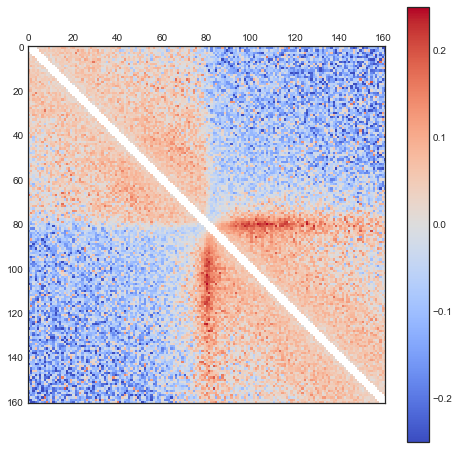

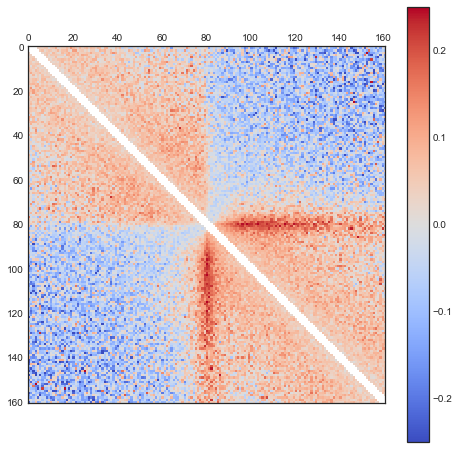

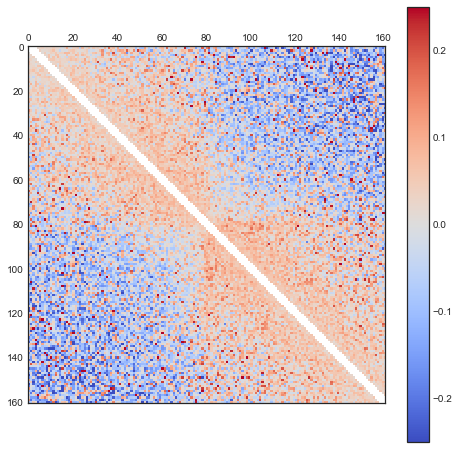

In [41]:
for cond in ['U', 'T', 'N']:
    expected = pd.read_csv('{}.{}.expected.txt'.format(longnames[cond], binsize))
    snipper = CoolerSnipper(clrs[cond], expected)
    
    windows, stack = pileup(windows, snipper.select, snipper.snip)
    mask = np.array(windows.strand == '+', dtype=bool)
    stack[:, :, mask] = stack[::-1, ::-1, mask]
    
    plt.figure(figsize=(8, 8))

    ax = plt.subplot(111)
    img = ax.matshow(np.log10(np.nanmean(stack, axis=2)), cmap='coolwarm', vmin=-0.25, vmax=0.25)
    plt.colorbar(img)